# 1. Libraries & Sample Data

In [1]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load Python Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import yfinance as yf

pd.set_option("display.max_rows", None)

In [3]:
# Download Data
data = yf.download(
    "TSLA", 
    start="2024-01-01",
    end="2026-01-22",
    interval="1d",
    multi_level_index=False
)

print(data.shape)
print(data.head())

[*********************100%***********************]  1 of 1 completed

(515, 5)
                 Close        High         Low        Open     Volume
Date                                                                 
2024-01-02  248.419998  251.250000  244.410004  250.080002  104654200
2024-01-03  238.449997  245.679993  236.320007  244.979996  121082600
2024-01-04  237.929993  242.699997  237.729996  239.250000  102629300
2024-01-05  237.490005  240.119995  234.899994  236.860001   92488900
2024-01-08  240.449997  241.250000  235.300003  236.139999   85166600


# 2. Exploratory Data Analysis / Data Cleaning

<Axes: xlabel='Date'>

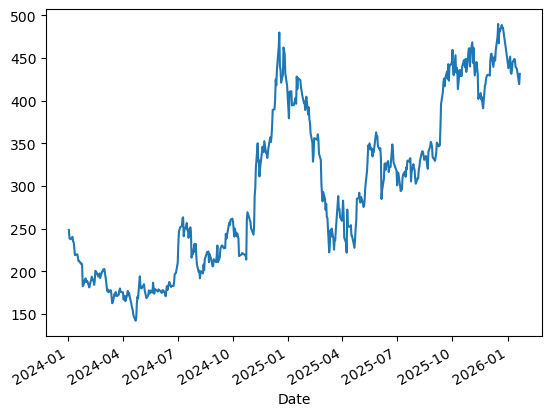

In [4]:
# Plot the Close Data
data['Close'].plot()

In [5]:
# Check for null values
print('Number of Null Values =', data.isnull().sum())

Number of Null Values = Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


# 3. Feature Definition
Create Features: 5-day & 20-day Close Moving Average, 20-day Close Bollinger Bands, and 20-day Historical Volatility of Close Price. 

In [5]:
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
data['STD20'] = data['Close'].rolling(window=20).std()
data['BB_upper'] = data['MA20'] + (data['STD20'] * 2)
data['BB_lower'] = data['MA20'] - (data['STD20'] * 2)
data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))
data['Vol20'] = data['Log_Ret'].rolling(window=20).std() * np.sqrt(252)
print(data.shape)
print(data.head())

(515, 12)
                 Close        High         Low        Open     Volume  \
Date                                                                    
2024-01-02  248.419998  251.250000  244.410004  250.080002  104654200   
2024-01-03  238.449997  245.679993  236.320007  244.979996  121082600   
2024-01-04  237.929993  242.699997  237.729996  239.250000  102629300   
2024-01-05  237.490005  240.119995  234.899994  236.860001   92488900   
2024-01-08  240.449997  241.250000  235.300003  236.139999   85166600   

                   MA5  MA20  STD20  BB_upper  BB_lower   Log_Ret  Vol20  
Date                                                                      
2024-01-02         NaN   NaN    NaN       NaN       NaN       NaN    NaN  
2024-01-03         NaN   NaN    NaN       NaN       NaN -0.040961    NaN  
2024-01-04         NaN   NaN    NaN       NaN       NaN -0.002183    NaN  
2024-01-05         NaN   NaN    NaN       NaN       NaN -0.001851    NaN  
2024-01-08  240.547998   NaN

In [6]:
# Remove rows with NaN
data = data.dropna(axis=0)
print(data.shape)

(495, 12)


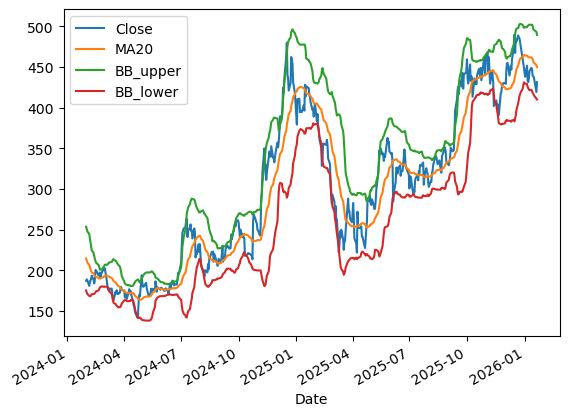

In [7]:
# Plot Features: Close, MA20, BB Upper, BB Lower
data['Close'].plot()
data['MA20'].plot()
data['BB_upper'].plot()
data['BB_lower'].plot()

plt.legend() 
plt.show()

# 4. Rolling Z-Score Normalization

In [8]:
dataset = data.reset_index()[['Date', 'Close', 'MA5', 'MA20', 'BB_upper', 'BB_lower', 'Vol20']]
print(dataset.head())

        Date       Close         MA5        MA20    BB_upper    BB_lower  \
0 2024-01-31  187.289993  187.137997  214.516000  253.620280  175.411721   
1 2024-02-01  188.860001  188.383997  212.036501  251.039531  173.033470   
2 2024-02-02  187.910004  189.315997  209.535501  247.958049  171.112953   
3 2024-02-05  181.059998  187.341998  206.714001  244.779237  168.648764   
4 2024-02-06  185.100006  186.044000  203.946501  239.660089  168.232913   

      Vol20  
0  0.522707  
1  0.518415  
2  0.517821  
3  0.523939  
4  0.531373  


In [9]:
step = 30  # rolling window length
numeric_cols = dataset.select_dtypes(include=[np.number]).columns

# Rolling mean/std using past 'step' values + current, no future
roll_mean = dataset[numeric_cols].rolling(window=step, min_periods=step).mean()
roll_std  = dataset[numeric_cols].rolling(window=step, min_periods=step).std(ddof=0)

normed = (dataset[numeric_cols] - roll_mean) / roll_std

normed_dataset = pd.concat([normed, dataset.drop(columns=numeric_cols)], axis=1)[dataset.columns]

print(normed_dataset.shape)
print(normed_dataset.head())

# Remove rows with NaN
normed_dataset = normed_dataset.dropna(axis=0)
print(normed_dataset.shape)
print(normed_dataset.head())


(495, 7)
        Date  Close  MA5  MA20  BB_upper  BB_lower  Vol20
0 2024-01-31    NaN  NaN   NaN       NaN       NaN    NaN
1 2024-02-01    NaN  NaN   NaN       NaN       NaN    NaN
2 2024-02-02    NaN  NaN   NaN       NaN       NaN    NaN
3 2024-02-05    NaN  NaN   NaN       NaN       NaN    NaN
4 2024-02-06    NaN  NaN   NaN       NaN       NaN    NaN
(466, 7)
         Date     Close       MA5      MA20  BB_upper  BB_lower     Vol20
29 2024-03-13 -2.173582 -2.162958 -0.863202 -0.326670 -1.540831 -0.251772
30 2024-03-14 -2.526294 -2.332935 -1.060290 -0.136851 -2.270600 -0.165318
31 2024-03-15 -2.144783 -2.322483 -1.403415 -0.068434 -2.573259 -1.080713
32 2024-03-18 -1.151672 -2.145109 -1.706893 -0.104017 -2.427638 -0.066135
33 2024-03-19 -1.307498 -2.047872 -1.986337 -0.080249 -2.375796 -0.159802


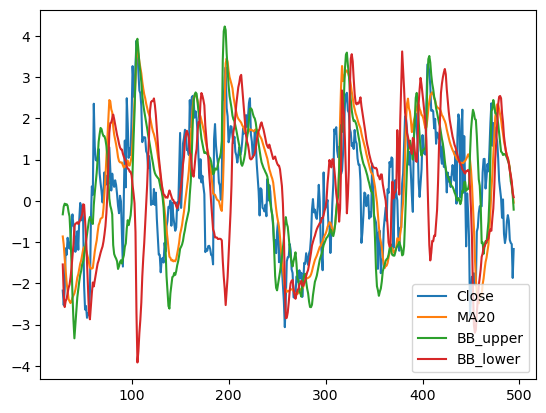

In [10]:
# Plot Normalized Features
normed_dataset['Close'].plot()
normed_dataset['MA20'].plot()
normed_dataset['BB_upper'].plot()
normed_dataset['BB_lower'].plot()

plt.legend() 
plt.show()

In [11]:
# adding normalised data to raw data
df = pd.merge(dataset, normed_dataset, on='Date', suffixes=('', '_normed'))
print(dataset.shape)
print(normed_dataset.shape)
print(df.shape)
print(df.head())

(495, 7)
(466, 7)
(466, 13)
        Date       Close         MA5        MA20    BB_upper    BB_lower  \
0 2024-03-13  169.479996  175.755997  189.845499  211.725466  167.965531   
1 2024-03-14  162.500000  172.525998  188.534998  213.608030  163.461966   
2 2024-03-15  163.570007  170.172000  186.690999  213.442870  159.939128   
3 2024-03-18  173.800003  169.378000  185.383499  211.962410  158.804588   
4 2024-03-19  171.320007  168.134003  184.261500  211.243059  157.279941   

      Vol20  Close_normed  MA5_normed  MA20_normed  BB_upper_normed  \
0  0.489001     -2.173582   -2.162958    -0.863202        -0.326670   
1  0.493808     -2.526294   -2.332935    -1.060290        -0.136851   
2  0.428391     -2.144783   -2.322483    -1.403415        -0.068434   
3  0.496622     -1.151672   -2.145109    -1.706893        -0.104017   
4  0.489120     -1.307498   -2.047872    -1.986337        -0.080249   

   BB_lower_normed  Vol20_normed  
0        -1.540831     -0.251772  
1        -2.270600

In [12]:
df.to_csv('TSLA_2024_2026_1d_norm30.csv', index=False)